Epoch 0, Loss: 0.48395830392837524
Epoch 100, Loss: 0.05836435779929161
Epoch 200, Loss: 0.00786397885531187
Epoch 300, Loss: 0.0010123810498043895
Epoch 400, Loss: 0.00018975950661115348
Epoch 500, Loss: 0.00012833811342716217
Epoch 600, Loss: 0.00012673730088863522
Epoch 700, Loss: 0.00012001892173429951
Epoch 800, Loss: 0.00012203613005112857
Epoch 900, Loss: 0.00011764655937440693
Epoch 1000, Loss: 0.00011949246982112527
Epoch 1100, Loss: 0.0001223006402142346
Epoch 1200, Loss: 0.00011668952356558293
Epoch 1300, Loss: 0.00011745397205231711
Epoch 1400, Loss: 0.00012202742072986439
Epoch 1500, Loss: 0.00012061819870723411
Epoch 1600, Loss: 0.00011510186595842242
Epoch 1700, Loss: 0.00011166205513291061
Epoch 1800, Loss: 0.00010946220572805032
Epoch 1900, Loss: 0.00011101133713964373
800/800 [==============================] - 0s 307us/step
u_pred_shape: (100, 256)


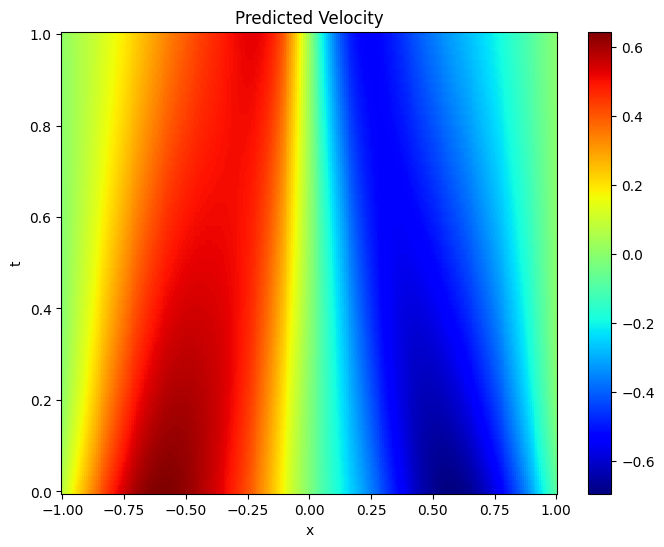

epoch: 1999


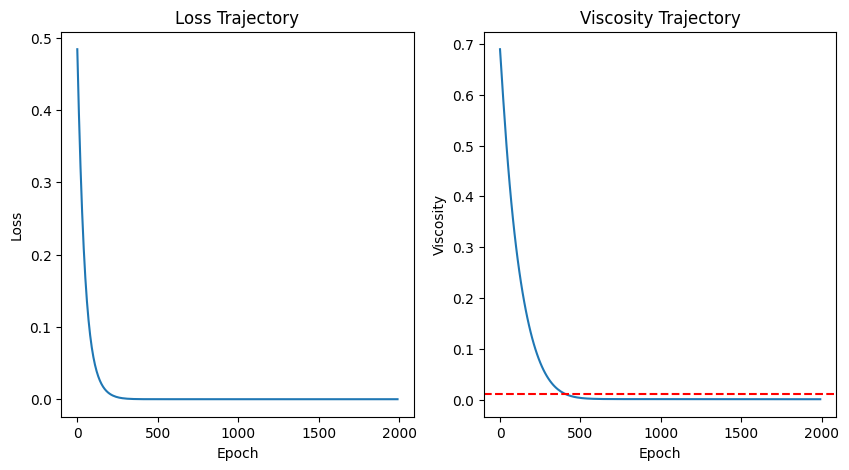

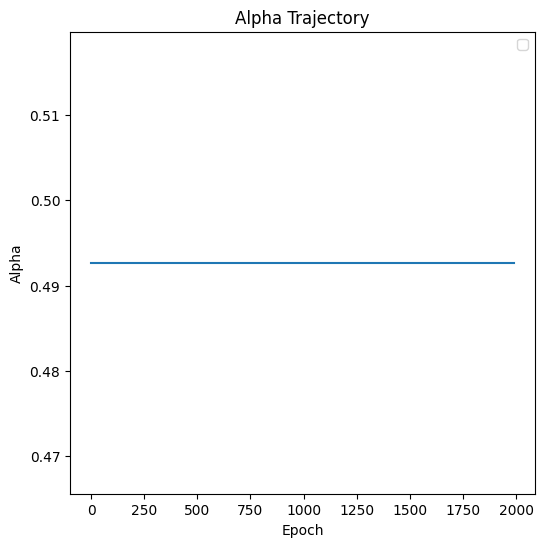

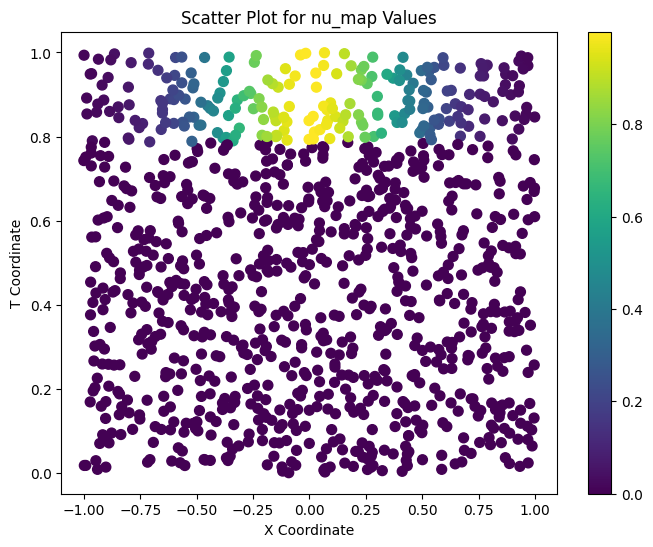

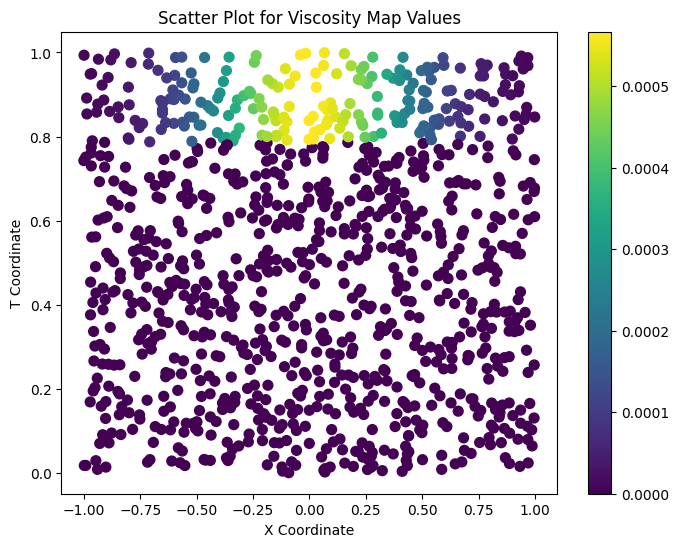

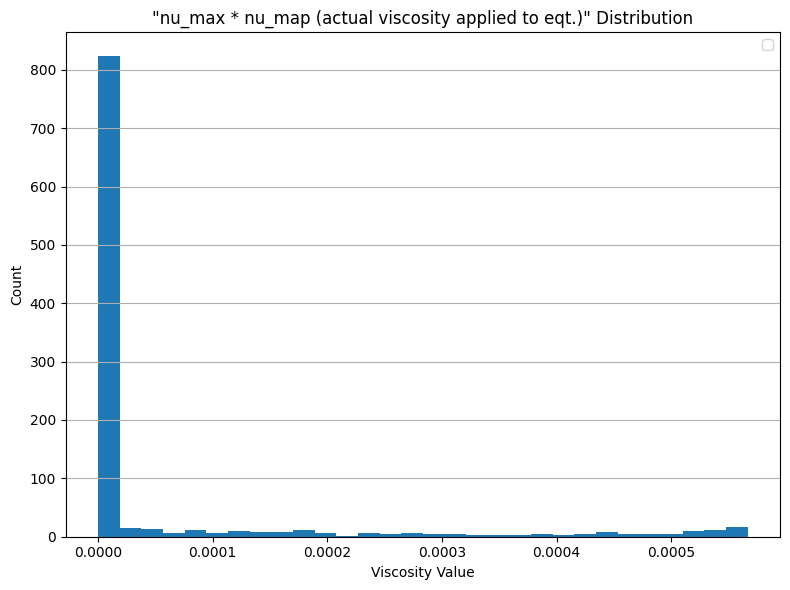

nu_max:  <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.0005666614>
alpha: <tf.Variable 'alpha_nu_loss_coeffcient:0' shape=() dtype=float32, numpy=0.49268454>
batch sizes: [1024, 1024, 1024]
t_shock: <tf.Variable 'shock_happen_time:0' shape=() dtype=float32, numpy=0.78702545>
std_dev: <tf.Variable 'standard_deviation_for_GD:0' shape=() dtype=float32, numpy=0.33958843>


In [3]:
# v?? 17 Oct 2023 
# artificial viscosity - achieved with TF variables
# made adjustment on IC/BC loss functions

## global AV:

## parametric method:
# ###### the shock width decreases with time ###### and loss and nu_max trajectory shows reasonable.
# However the theta_map and nu_map show random values all over the place without the "Gaussian distribution"
# Designate the Gaussian distribution over the viscosity map
# Include t_shock and std_dev as part of the learnable variables


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=tf.ones([]) * viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=tf.ones([]) * 1,
                                 trainable=True,
                                 dtype=tf.float32,
                                 name="alpha_nu_loss_coeffcient")
        self.theta = tf.Variable(initial_value=tf.ones([batch_size[0], 1]) * 0.5, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="viscosity_map_coefficient")
        self.t_shock = tf.Variable(initial_value=0.5, 
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="shock_happen_time")
        self.std_dev = tf.Variable(initial_value=0.3,
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="standard_deviation_for_GD")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

def viscosity_mapping(x, t, epoch):
    nu_map = np.where(t >= domain.t_shock, np.exp(-((x - 0) ** 2) / (2 * domain.std_dev ** 2)), 0) # * domain.theta  # gaussian_distribution
    viscosity = domain.viscosity * nu_map # tf.sigmoid(nu_map)
    storage = [x, t, nu_map, viscosity, epoch] # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    return storage 

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, epoch):
    
    # define a viscosity map, displaying the preference of AV on domain
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        t_shock_broadcasted = tf.fill(x.shape, domain.t_shock) # make shape compatible for the network inputs [epoch_number,1]
        std_dev_broadcasted = tf.fill(x.shape, domain.std_dev) # make shape compatible for the network inputs [epoch_number,1]
        u = network(tf.concat([x, t, t_shock_broadcasted, std_dev_broadcasted], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")
        
        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        parameter_storage = viscosity_mapping(x, t, epoch)

        # Define the Burgers equation residual
        residual = u_t + u * u_x - parameter_storage[3] * u_xx
        # viscosity_map: nu_max * nu_map
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    t_batch_0 = tf.fill([domain.batch_size_0, 1], 0.0001) # considered as 0 #TODO check if it's small enough or feasible
    x_batch_0 = tf.random.uniform([domain.batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0, 
                             tf.fill(x_batch_0.shape, domain.t_shock), 
                             tf.fill(x_batch_0.shape, domain.std_dev)], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    x_batch_bl = tf.cast(tf.fill([domain.batch_size_b, 1], -1), dtype=tf.float32) # int32 and float incompatible
    x_batch_br = tf.cast(tf.fill([domain.batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([domain.batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b, 
                              tf.fill(x_batch_bl.shape, domain.t_shock), 
                              tf.fill(x_batch_bl.shape, domain.std_dev)], axis=1)) 
    u_br = network(tf.concat([x_batch_br, t_batch_b, 
                              tf.fill(x_batch_br.shape, domain.t_shock),
                              tf.fill(x_batch_br.shape, domain.std_dev)], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, domain.x_min, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, domain.x_max, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(tf.reduce_max(domain.viscosity)) # square the maximum element
    loss = tf.reduce_mean(tf.square(residual)) / domain.batch_size_r + \
           tf.reduce_mean(tf.square(initial_residual)) / domain.batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / domain.batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / domain.batch_size_b + \
            domain.alpha * viscosity_loss
    
    # print("viscosity map: ",  domain.viscosity * _viscosity_map) # 256,1
    return loss, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)), # x, t, t_shock, std_dev for the GD
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # List to store loss and viscosity values for each epoch
    history = [[] for _ in range(5)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: t_shock

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss, parameter_s = physics_informed_loss(network, domain, x_batch, t_batch, epoch)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] + \
                        [domain.alpha] + [domain.t_shock] + [domain.std_dev]# [domain.theta] # theta no longer in use, instead considered as theta(t_shock, std_dev)

        gradients = tape.gradient(loss, variable_list)
        optimizer.apply_gradients(zip(gradients, variable_list))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(tf.reduce_max(domain.viscosity).numpy())
            history[2].append(domain.t_shock)
            history[3].append(domain.std_dev)
            history[4].append(domain.alpha)
            # theta_history.append(domain.theta)
    
        # if epoch % 4999 == 0:
            # print("epoch reached 4999")
        # for the last epoch
            # output the x_batch and t_batch from the PI_loss function
            # match the x and t to its velocity map and velocity max

    return network, history, parameter_s

# Visualize the results
def visualize_results(model, domain, history, num_epochs, parameter_s):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    t_shock_grid = np.full_like(x_grid, domain.t_shock)
    std_dev_grid = np.full_like(x_grid, domain.std_dev)
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], 
                   t_grid.flatten()[:, tf.newaxis], 
                   t_shock_grid.flatten()[:, tf.newaxis],
                   std_dev_grid.flatten()[:, tf.newaxis]))
    #print(X.shape)
    u_pred_grid = model.predict(X)
    # print(u_pred_grid.shape)
    u_pred_grid = griddata(X[:, 0:2], u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[4]) # alpha trajectory
    plt.xlabel('Epoch')
    plt.ylabel('Alpha')
    plt.title('Alpha Trajectory')
    plt.legend()



    # plot the viscosity map
    # parameter_s components: 0x, 1t, 2nu_map, 3nu, 4epoch
    x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    nu_map = np.array(parameter_s[2])     # Convert to NumPy array
    nu = np.array(parameter_s[3])         # Convert to NumPy array
    epoch = np.array(parameter_s[4])
    print("epoch:", epoch)

    # Create the scatter plot

    plt.figure(figsize=(8, 6))
    scatter1 = plt.scatter(x_coords, y_coords, c=nu_map, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter1)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for nu_map Values')

    plt.figure(figsize=(8, 6))
    scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter2)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for Viscosity Map Values')

    # Create a histogram of nu
    plt.figure(figsize=(8, 6))
    plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    plt.xlabel('Viscosity Value')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_t = 100
    batch_size_r=1024
    num_batch_size_0 = 1024
    num_batch_size_b = 1024
    batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size)
    num_epochs = 2000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, history, parameter_s = train_model(network,
                                              domain, 
                                              num_epochs, 
                                              learning_rate=0.005)

    # Visualize the results
    u_pred_grid = visualize_results(model, 
                                    domain, 
                                    history, 
                                    num_epochs,
                                    parameter_s)

    #TODO compare the u_pred_grid with the analytical solution

    print("nu_max: ", domain.viscosity)
    print("alpha:", domain.alpha)
    print("batch sizes:", batch_size)
    try:
        # Attempt to access the variable
        domain.t_shock
        print("t_shock:", domain.t_shock)
        print("std_dev:", domain.std_dev)
    except NameError:
        print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
   
    




In [4]:
import scipy
import numpy as np
import tensorflow as tf

data = scipy.io.loadmat('burgers_shock.mat')

Exact = data['usol']
Exact_u = np.real(Exact)

print(Exact_u.shape)
# t = data['tt'].flatten()[:,None]
# x = data['x'].flatten()[:,None]
x_grid, t_grid = np.meshgrid(np.linspace(-1, 1, 256),
                             np.linspace(0, 1, 100))
X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
u_pred_grid = model.predict(X)
u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

# x = Domain.domaindict[0]['xlinspace']
# t = Domain.domaindict[1]["tlinspace"]

# X, T = np.meshgrid(x, t)

# # print(np.shape((X,T))) #2, 100, 256
# X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
print(u_star.shape)

(256, 100)


InvalidArgumentError: Graph execution error:

Detected at node sequential_2/dense_6/BiasAdd defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/b8/gmwfy7_j39n1yx71kb8wfxf1d1yljv/T/ipykernel_5078/2893199396.py", line 16, in <module>

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/e0919678/tensorflow/lib/python3.9/site-packages/keras/src/layers/core/dense.py", line 252, in call

Matrix size-incompatible: In[0]: [32,2], In[1]: [4,32]
	 [[{{node sequential_2/dense_6/BiasAdd}}]] [Op:__inference_predict_function_5419709]